# Historical Coin Classifier

An image classifier to recognize different types of historical coins using TensorFlow and transfer learning.

In [1]:
# Install tensorflow package
!pip install tensorflow pillow


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\texx0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import urllib.request
from PIL import Image

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 8)

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.20.0


# Load the Coin Data

In [2]:
# Point to your coin data folder
data_dir = Path("data/coins")

# List all classes (subdirectories)
class_names = [d.name for d in data_dir.iterdir() if d.is_dir()]
print(f"Found {len(class_names)} coin categories: {class_names}")
    
# Count images in each class
print("\nImage counts per category:")
for class_name in class_names:
    class_path = data_dir / class_name
    image_count = len(list(class_path.glob("*")))
    print(f"   {class_name}: {image_count} images")
    if image_count < 20:
        print(f"      Warning: Less than 20 images - consider adding more for better results, more the better :)")

Found 6 coin categories: ['augustus', 'constantine', 'hadrian', 'marcus_aurelius', 'nero', 'trajan']

Image counts per category:
   augustus: 17 images
   constantine: 13 images
   hadrian: 13 images
   marcus_aurelius: 16 images
   nero: 15 images
   trajan: 16 images


# Split Data into Training and Validation Sets

In [3]:
# Image parameters
IMG_HEIGHT = 224  # Standard size for most pre-trained models
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create training dataset (80% of data)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # One-hot encoding for multiple classes
)

# Create validation dataset (20% of data)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Get class names from the dataset
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Number of classes: 6
Class names: ['augustus', 'constantine', 'hadrian', 'marcus_aurelius', 'nero', 'trajan']
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Number of classes: 6
Class names: ['augustus', 'constantine', 'hadrian', 'marcus_aurelius', 'nero', 'trajan']


# Visualize Sample Training Images

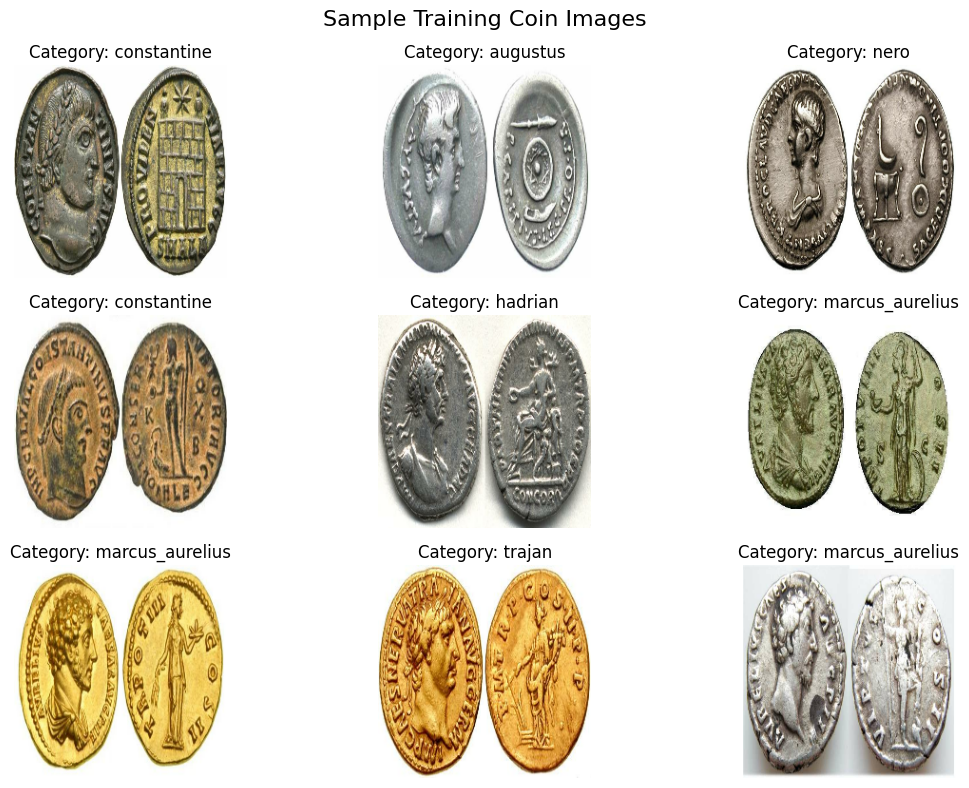

In [4]:
# Let's look at some of our training images
plt.figure(figsize=(12, 8))

# Take one batch of images and labels
for images, labels in train_ds.take(1):
    # Show first 9 images
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        
        # Convert image to displayable format
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        
        # Get the class name from the one-hot encoded label
        class_idx = np.argmax(labels[i])
        plt.title(f"Category: {class_names[class_idx]}")
        plt.axis("off")

plt.suptitle("Sample Training Coin Images", fontsize=16)
plt.tight_layout()
plt.show()

# Normalize and Optimize Data

In [ ]:
# Normalize pixel values to [0, 1] range
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to both datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Data preprocessing complete! :)")
print("Images are now normalized to [0, 1] range")

Data preprocessing complete! :)
Images are now normalized to [0, 1] range


# Build the Neural Network Model

In [ ]:


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,  # Don't include the final classification layer
    weights='imagenet'  # Use weights trained on ImageNet
)

# Freeze the base model
base_model.trainable = False


model = tf.keras.Sequential([
    base_model,                                    # Pre-trained feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),     # Convert features to 1D
    tf.keras.layers.Dropout(0.2),                 # Prevent overfitting
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Final classification layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("Neural Network Architecture:")
model.summary()

Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train the Model

In [7]:
# Set up training parameters
EPOCHS = 10  # Number of times to go through the entire dataset; more generally but not always gives better results

print(f"Starting training for {EPOCHS} epochs...")
print("This might take a few minutes...")

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1  # Show progress
)

print("Training complete! :)")

Starting training for 10 epochs...
This might take a few minutes...
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.0694 - loss: 2.2784 - val_accuracy: 0.1111 - val_loss: 1.9858
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.0694 - loss: 2.2784 - val_accuracy: 0.1111 - val_loss: 1.9858
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2361 - loss: 1.8190 - val_accuracy: 0.1667 - val_loss: 1.9653
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2361 - loss: 1.8190 - val_accuracy: 0.1667 - val_loss: 1.9653
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2917 - loss: 1.7518 - val_accuracy: 0.2222 - val_loss: 1.9455
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2917 - loss: 1.7518 - val_accuracy: 0.2222 - val_loss: 1.9455
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3333 - loss: 1.5907 - val_accuracy: 0.2222 - val_loss: 1.9369
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accu

# Evaluate Model Performance

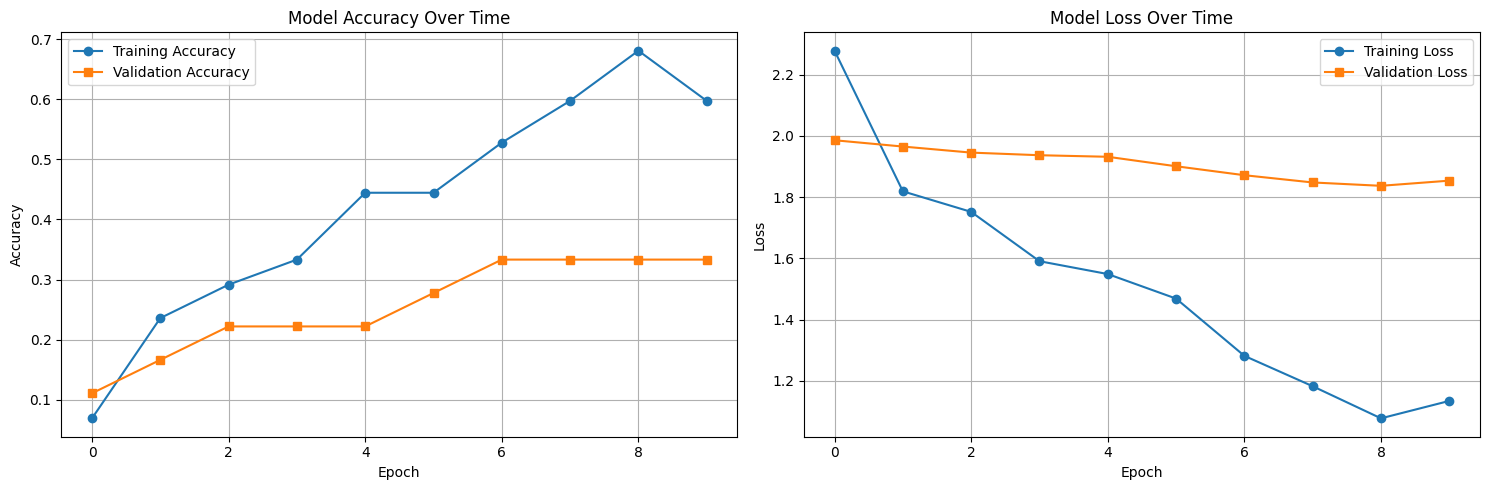

Final Validation Accuracy: 33.33%


In [8]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
ax1.set_title('Model Accuracy Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
ax2.set_title('Model Loss Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final results
final_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_acc:.2%}")

# Save the Trained Model

In [9]:
# Save the trained model
model_path = "coin_classifier_model.h5"
model.save(model_path)
print(f"Model saved as: {model_path}")

# To load the model later, use:
# loaded_model = tf.keras.models.load_model(model_path)

Model saved as: coin_classifier_model.h5


# Test Predictions on Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


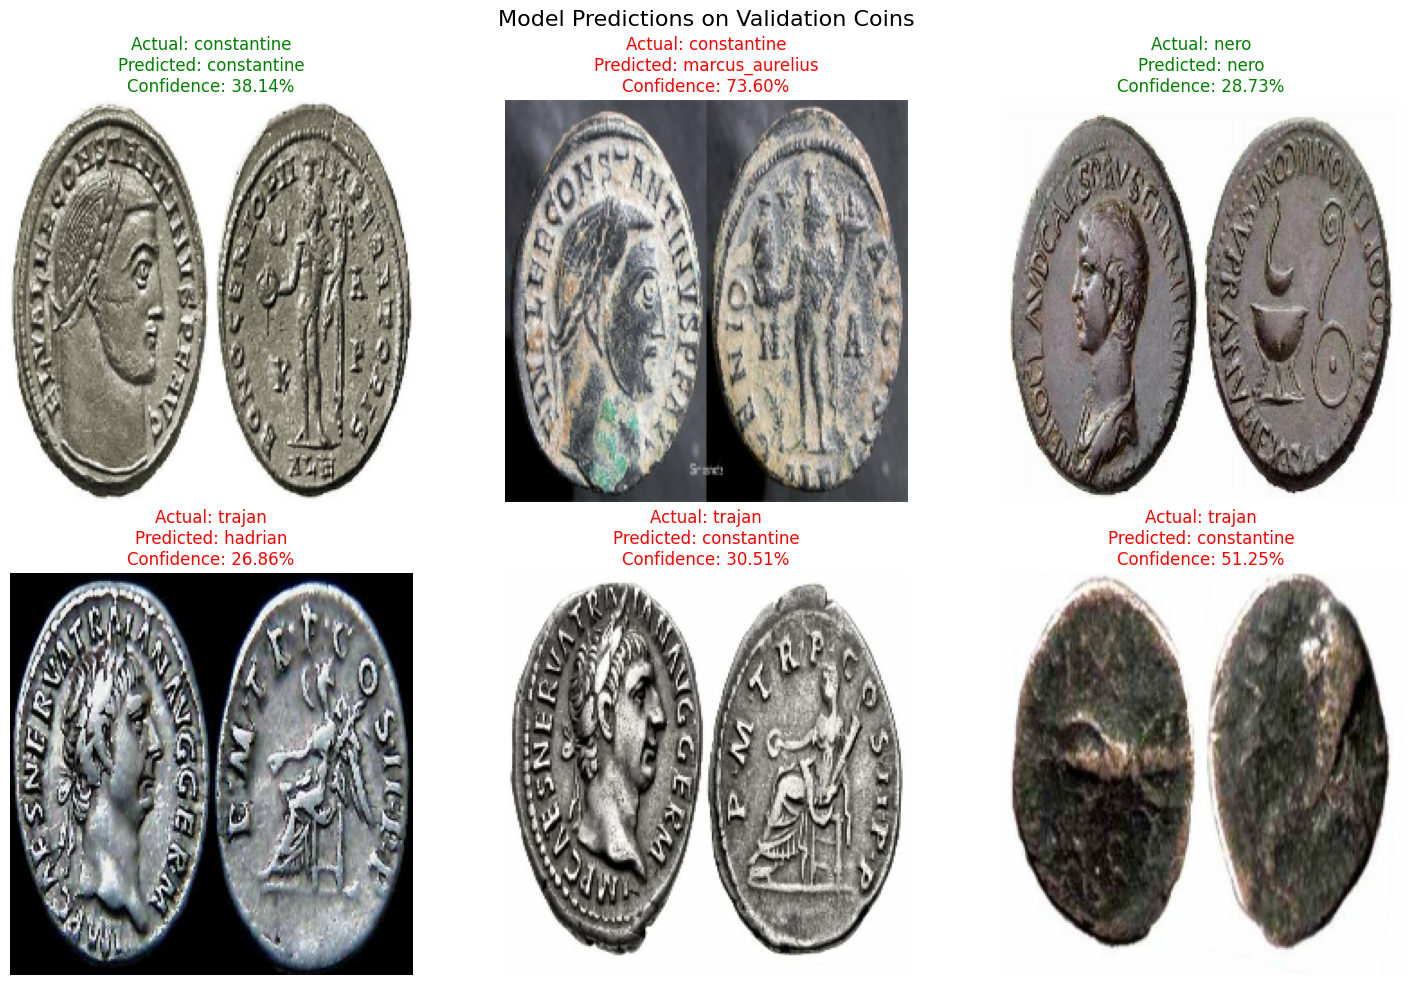

In [10]:
# Function to make predictions on a batch of images
def predict_and_display(dataset, num_images=6):
    """Display images with their predicted and actual labels"""
    
    plt.figure(figsize=(15, 10))
    
    # Get one batch of images
    for images, labels in dataset.take(1):
        # Make predictions
        predictions = model.predict(images)
        
        # Display the first num_images
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 3, i + 1)
            
            # Show image
            img = images[i].numpy()
            plt.imshow(img)
            
            # Get actual and predicted classes
            actual_class = class_names[np.argmax(labels[i])]
            predicted_class = class_names[np.argmax(predictions[i])]
            confidence = np.max(predictions[i])
            
            # Set title color based on correctness
            color = 'green' if actual_class == predicted_class else 'red'
            
            plt.title(f'Actual: {actual_class}\n'
                     f'Predicted: {predicted_class}\n'
                     f'Confidence: {confidence:.2%}', 
                     color=color)
            plt.axis('off')
    
    plt.suptitle('Model Predictions on Validation Coins', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show predictions
predict_and_display(val_ds)

# Predict on Single Images

In [16]:
# Create a function to predict a single image
def predict_single_image(image_path):
    """Predict the class of a single coin image"""
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}')
    plt.axis('off')
    plt.show()
    
    # Show confidence for all classes
    print("Confidence scores for all classes:")
    for i, class_name in enumerate(class_names):
        print(f"   {class_name}: {predictions[0][i]:.2%}")

# Test with Your Own Coin Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


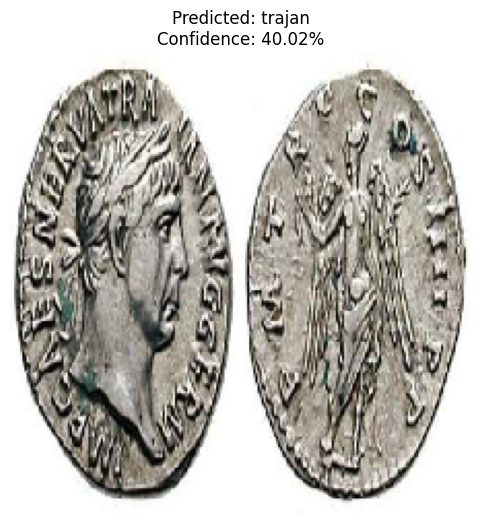

Confidence scores for all classes:
   augustus: 13.99%
   constantine: 5.62%
   hadrian: 13.54%
   marcus_aurelius: 11.47%
   nero: 15.36%
   trajan: 40.02%


In [17]:
# Test with a local coin image
# Make sure your coin image is named 'test_coin.jpg' and is in this directory
predict_single_image("test_coin.jpg")